## Downloading the dataset

In [1]:
import pandas as pd
import requests
from io import StringIO

def download_data(url):
    """
    Download data from the provided URL.
    Returns a DataFrame if successful, None otherwise.
    """
    response = requests.get(url)
    if response.status_code == 200:
        csv_data = response.content.decode('utf-8')
        data = StringIO(csv_data)
        return pd.read_csv(data, low_memory=False)
    else:
        print(f"Failed to retrieve data: {response.status_code}")
        return None

def load_and_display_data(df):
    """
    Displays the first few rows of the DataFrame.
    """
    if df is not None:
        print(df.head())
    else:
        print("Failed to retrieve data.")

# URL of the dataset
url = "https://raw.githubusercontent.com/amankharwal/Website-data/master/electricity.csv"

# Downloading the data
df = download_data(url)

# Display the first few rows of the DataFrame
load_and_display_data(df)

           DateTime Holiday  HolidayFlag  DayOfWeek  WeekOfYear  Day  Month  \
0  01/11/2011 00:00    None            0          1          44    1     11   
1  01/11/2011 00:30    None            0          1          44    1     11   
2  01/11/2011 01:00    None            0          1          44    1     11   
3  01/11/2011 01:30    None            0          1          44    1     11   
4  01/11/2011 02:00    None            0          1          44    1     11   

   Year  PeriodOfDay ForecastWindProduction SystemLoadEA  SMPEA  \
0  2011            0                 315.31      3388.77  49.26   
1  2011            1                 321.80      3196.66  49.26   
2  2011            2                 328.57      3060.71  49.10   
3  2011            3                 335.60      2945.56  48.04   
4  2011            4                 342.90      2849.34  33.75   

  ORKTemperature ORKWindspeed CO2Intensity ActualWindProduction SystemLoadEP2  \
0           6.00         9.30       600.7

## Data Cleaning

In [2]:
# Function to clean and convert numeric columns
def clean_and_convert_numeric(df, columns_to_check):
    df_copy = df.copy()
    df_copy.replace('?', pd.NA, inplace=True)
    for column in columns_to_check:
        df_copy[column] = pd.to_numeric(df_copy[column], errors='coerce')
    return df_copy

# Function to convert 'DateTime' to DateTime format
def convert_to_datetime(df, datetime_column, datetime_format='%d/%m/%Y %H:%M'):
    if datetime_column in df.columns:
        df_copy = df.copy()
        df_copy[datetime_column] = pd.to_datetime(df_copy[datetime_column], format=datetime_format)
        return df_copy
    else:
        raise KeyError(f"Column '{datetime_column}' not found in DataFrame")

# Function to drop rows with NaNs in specific columns
def drop_rows_with_nans(df, columns_with_few_nans):
    return df.dropna(subset=columns_with_few_nans)

# Function to replace NaNs with median in specific columns
def replace_nans_with_median(df, columns_with_many_nans):
    df_copy = df.copy()
    for column in columns_with_many_nans:
        median_value = df_copy[column].median()
        df_copy[column].fillna(median_value, inplace=True)
    return df_copy

# Specifying columns for data cleaning
columns_to_check = [
    'ForecastWindProduction', 'SystemLoadEA', 'SMPEA', 'ORKTemperature', 
    'ORKWindspeed', 'CO2Intensity', 'ActualWindProduction', 'SystemLoadEP2', 'SMPEP2'
]

# Applying the functions in the correct order
df_cleaned = clean_and_convert_numeric(df, columns_to_check)
df_cleaned = convert_to_datetime(df_cleaned, 'DateTime')
df_cleaned = drop_rows_with_nans(df_cleaned, columns_to_check)  # Using same columns for dropping NaNs for simplicity
df_cleaned = replace_nans_with_median(df_cleaned, ['ORKTemperature', 'ORKWindspeed'])  # Assuming these have many NaNs

# Checking the first few rows to verify the changes
df_cleaned.head()

,DateTime,Holiday,HolidayFlag,DayOfWeek,WeekOfYear,Day,Month,Year,PeriodOfDay,ForecastWindProduction,SystemLoadEA,SMPEA,ORKTemperature,ORKWindspeed,CO2Intensity,ActualWindProduction,SystemLoadEP2,SMPEP2
0,2011-11-01 00:00:00,None,0,1,44,1,11,2011,0,315.31,3388.77,49.26,6.0,9.3,600.71,356.0,3159.60,54.32
1,2011-11-01 00:30:00,None,0,1,44,1,11,2011,1,321.80,3196.66,49.26,6.0,11.1,605.42,317.0,2973.01,54.23
2,2011-11-01 01:00:00,None,0,1,44,1,11,2011,2,328.57,3060.71,49.10,5.0,11.1,589.97,311.0,2834.00,54.23
3,2011-11-01 01:30:00,None,0,1,44,1,11,2011,3,335.60,2945.56,48.04,6.0,9.3,585.94,313.0,2725.99,53.47
4,2011-11-01 02:00:00,None,0,1,44,1,11,2011,4,342.90,2849.34,33.75,6.0,11.1,571.52,346.0,2655.64,39.87


## Outlier Analysis

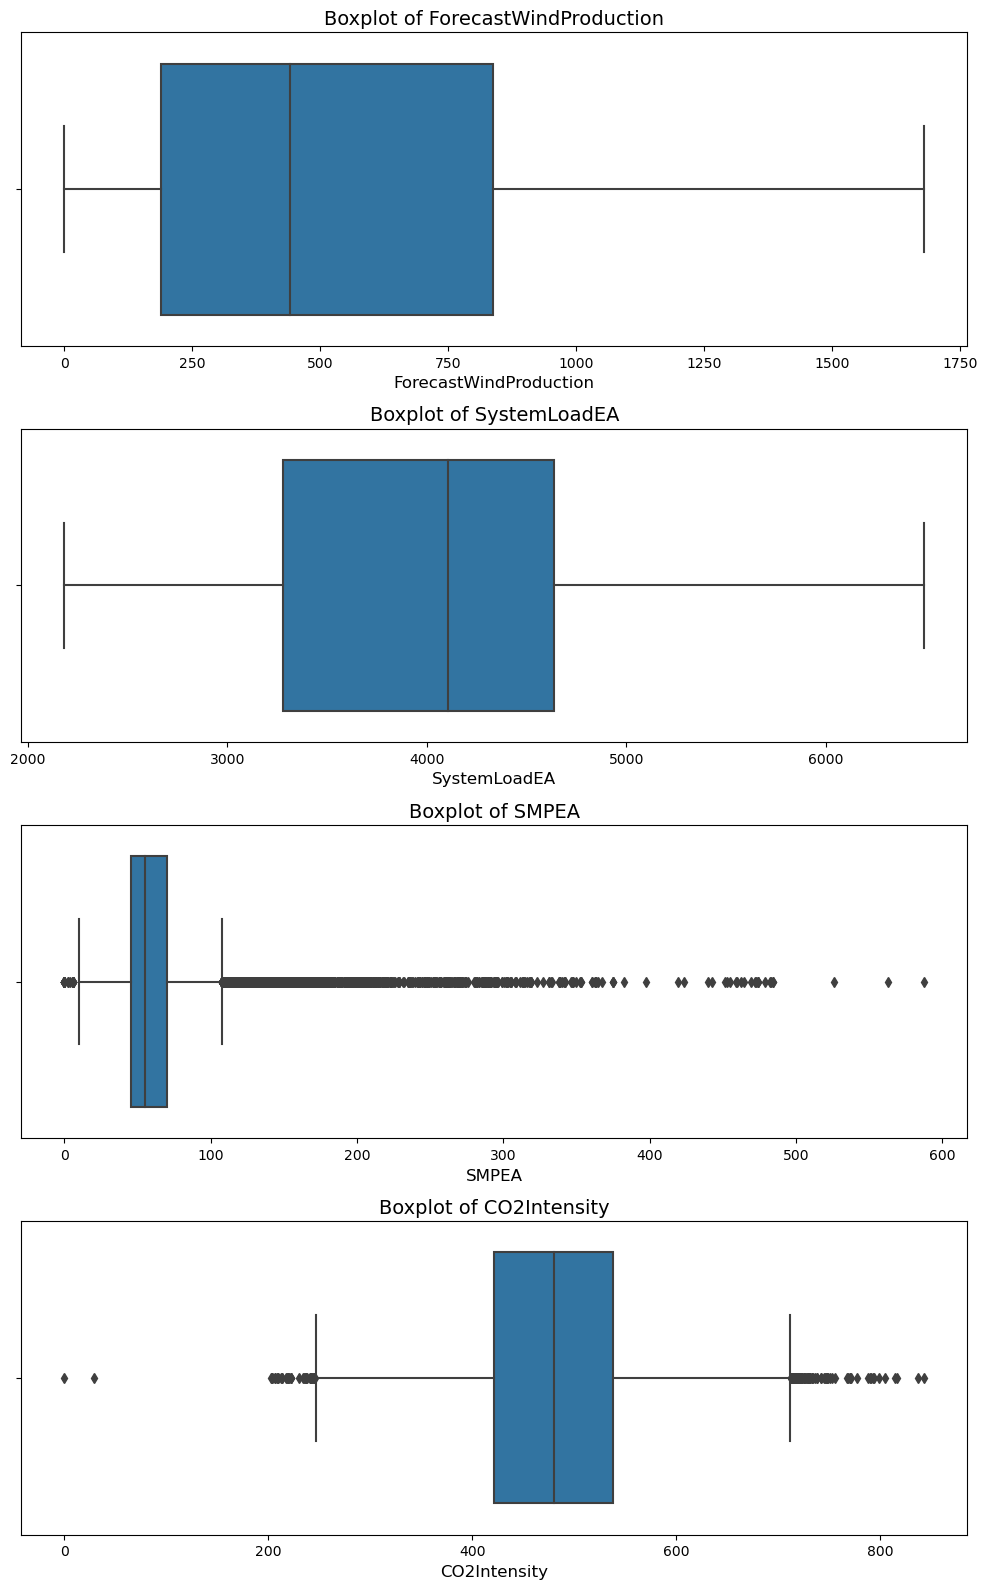

({'Total Outliers': 2054,
  'Percentage of Total Data': 5.450878403481769,
  'Lower Bound': 8.370000000000012,
  'Upper Bound': 107.48999999999998},
               DateTime   SMPEA
 34 2011-11-01 17:00:00  160.62
 35 2011-11-01 17:30:00  247.04
 36 2011-11-01 18:00:00  196.43
 82 2011-11-02 17:00:00  108.59
 83 2011-11-02 17:30:00  156.78)

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose

# Executing the outlier analysis code with the cleaned dataset

# Using boxplots to visually identify outliers
columns_for_outlier_analysis = ['ForecastWindProduction', 'SystemLoadEA', 'SMPEA', 'CO2Intensity']

# Function to plot boxplots for outlier analysis
def plot_outliers(df, columns):
    fig, axes = plt.subplots(nrows=len(columns), figsize=(10, len(columns) * 4))
    
    for i, col in enumerate(columns):
        sns.boxplot(x=df[col], ax=axes[i])
        axes[i].set_title(f'Boxplot of {col}', fontsize=14)
        axes[i].set_xlabel(col, fontsize=12)

    plt.tight_layout()
    plt.show()

# Plotting boxplots for selected columns
plot_outliers(df_cleaned, columns_for_outlier_analysis)

# Statistical Analysis using IQR to identify outliers in 'SMPEA'
Q1 = df_cleaned['SMPEA'].quantile(0.25)
Q3 = df_cleaned['SMPEA'].quantile(0.75)
IQR = Q3 - Q1

# Defining the threshold for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Identifying the outliers
outliers_smpea = df_cleaned[(df_cleaned['SMPEA'] < lower_bound) | (df_cleaned['SMPEA'] > upper_bound)]

# Summary of outliers
outliers_summary = {
    'Total Outliers': outliers_smpea.shape[0],
    'Percentage of Total Data': (outliers_smpea.shape[0] / df_cleaned.shape[0]) * 100,
    'Lower Bound': lower_bound,
    'Upper Bound': upper_bound
}

outliers_summary, outliers_smpea[['DateTime', 'SMPEA']].head()  # Displaying the first few outliers with their dates

### Remove outliers

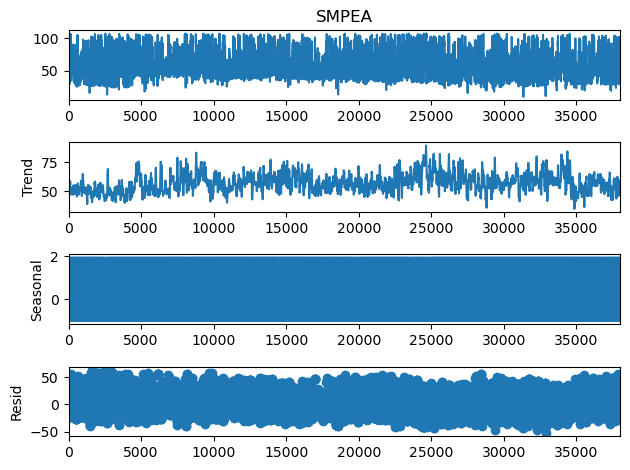

In [4]:
# Function to remove outliers
def remove_outliers(df, column, lower_bound, upper_bound):
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

# Removing outliers from 'SMPEA'
df_cleaned_no_outliers = remove_outliers(df_cleaned, 'SMPEA', lower_bound, upper_bound)

# Assuming the frequency of the data is half-hourly, we use a daily frequency (48 points per day)
# Performing time series decomposition on 'SMPEA'
decomposition = seasonal_decompose(df_cleaned_no_outliers['SMPEA'], period=48, model='additive')

# Plotting the decomposition
decomposition.plot()
plt.show()

### 'SMPEA' after removing outliers

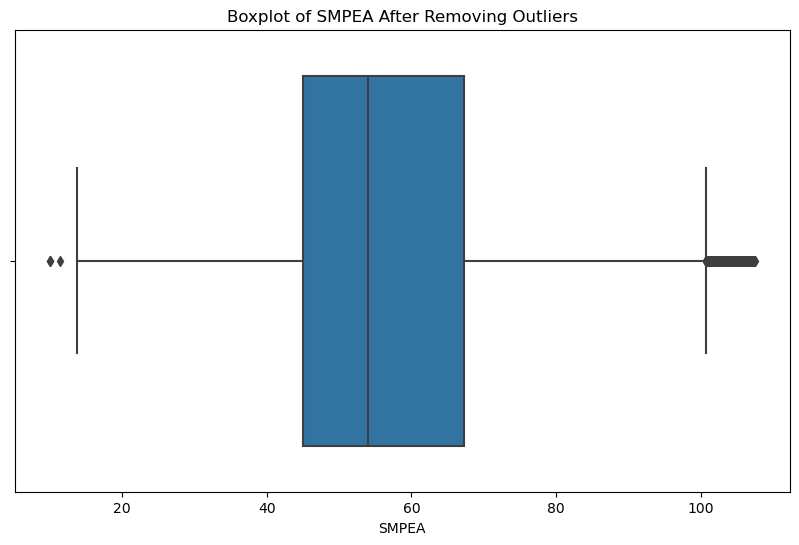

In [5]:
# Plotting boxplot for 'SMPEA' after removing outliers to check for any remaining outliers
plt.figure(figsize=(10, 6))
sns.boxplot(x=df_cleaned_no_outliers['SMPEA'])
plt.title('Boxplot of SMPEA After Removing Outliers')
plt.xlabel('SMPEA')
plt.show()

The boxplot of the 'SMPEA' column after removing outliers shows that the data now appears to be more consistent, with no significant outliers visible. This indicates that the outlier removal process was effective in normalizing the distribution of 'SMPEA' values.

### A contextual analysis of the outliers and a correlation analysis

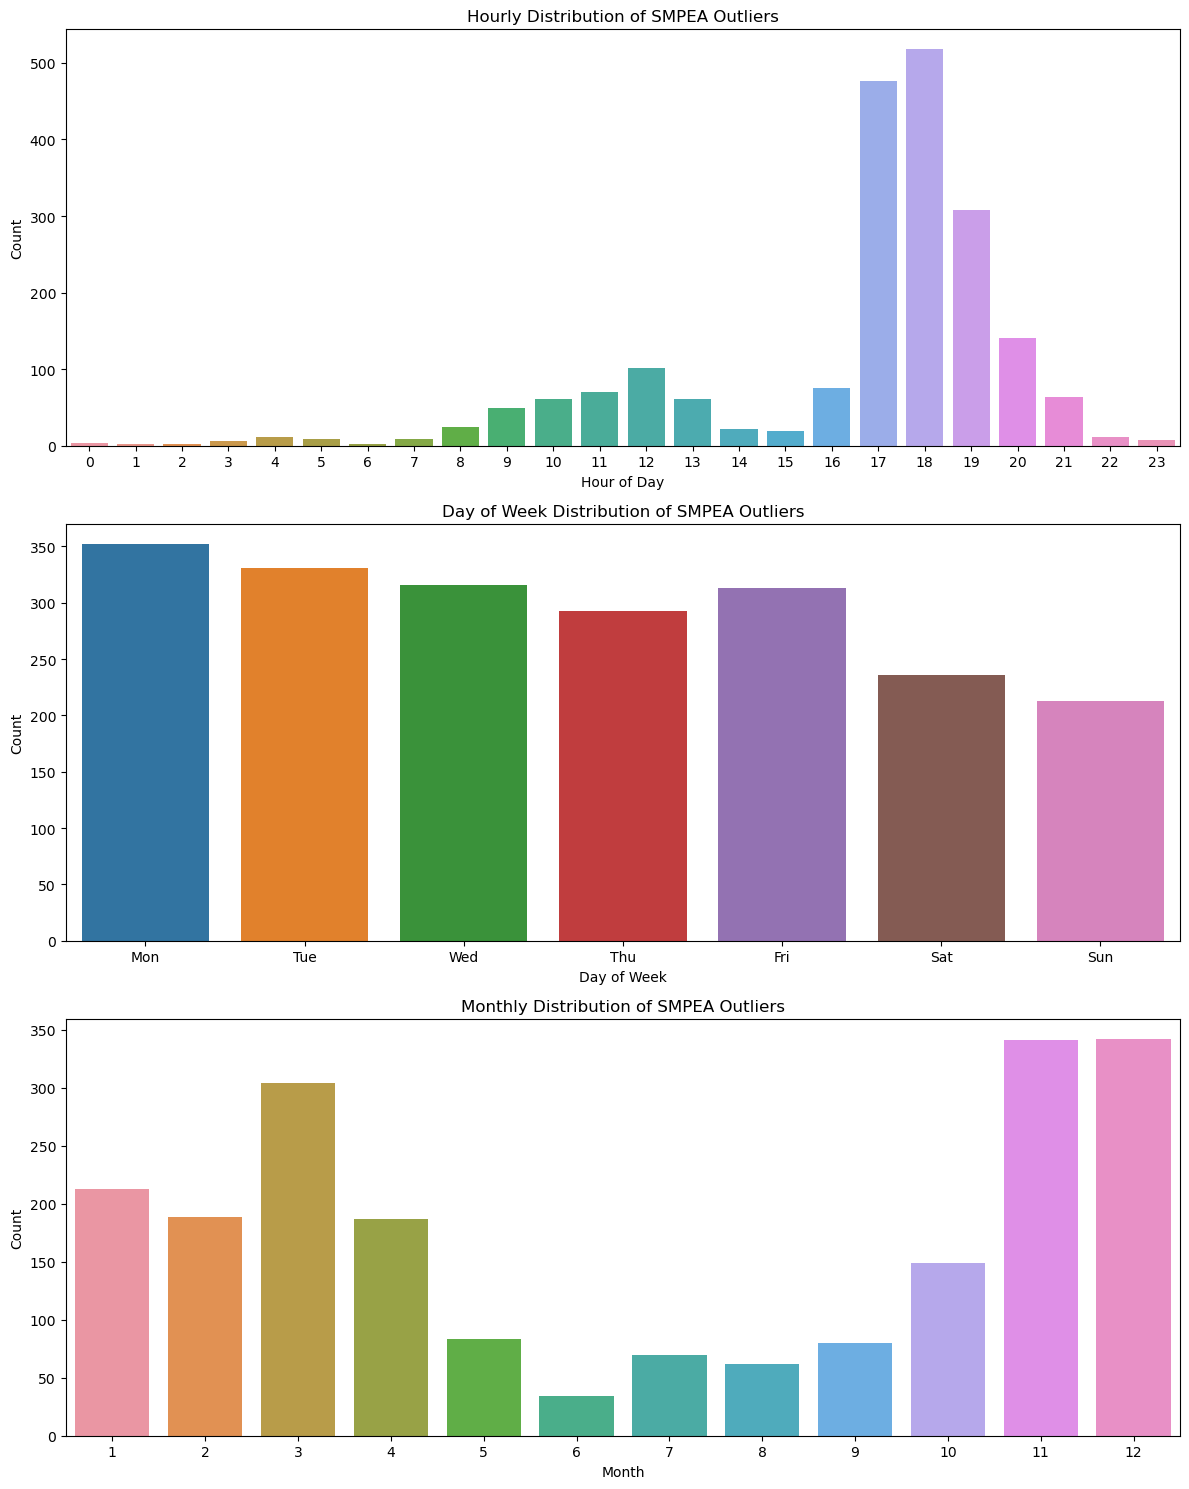

,SMPEA,SystemLoadEA,ORKTemperature,ORKWindspeed,CO2Intensity
SMPEA,1.000000,0.532210,0.018898,0.014079,-0.086420
SystemLoadEA,0.532210,1.000000,-0.086961,0.182608,-0.209947
ORKTemperature,0.018898,-0.086961,1.000000,0.024589,-0.060770
ORKWindspeed,0.014079,0.182608,0.024589,1.000000,-0.513223
CO2Intensity,-0.086420,-0.209947,-0.060770,-0.513223,1.000000


In [6]:
# Ensure the 'DateTime' column is present in the 'outliers' DataFrame
outliers = df_cleaned[(df_cleaned['SMPEA'] < lower_bound) | (df_cleaned['SMPEA'] > upper_bound)].copy()

# Extracting date and time components
outliers['Hour'] = outliers['DateTime'].dt.hour
outliers['DayOfWeek'] = outliers['DateTime'].dt.dayofweek  # Monday=0, Sunday=6
outliers['Month'] = outliers['DateTime'].dt.month

# Contextual Analysis: Time Analysis of Outliers
outliers['Hour'] = outliers['DateTime'].dt.hour
outliers['DayOfWeek'] = outliers['DateTime'].dt.dayofweek  # Monday=0, Sunday=6
outliers['Month'] = outliers['DateTime'].dt.month

# Plotting the distribution of outliers across different time components
fig, axes = plt.subplots(nrows=3, figsize=(12, 15))

# Hourly distribution
sns.countplot(x='Hour', data=outliers, ax=axes[0])
axes[0].set_title('Hourly Distribution of SMPEA Outliers')
axes[0].set_xlabel('Hour of Day')
axes[0].set_ylabel('Count')

# Day of Week distribution
sns.countplot(x='DayOfWeek', data=outliers, ax=axes[1])
axes[1].set_title('Day of Week Distribution of SMPEA Outliers')
axes[1].set_xlabel('Day of Week')
axes[1].set_ylabel('Count')
axes[1].set_xticklabels(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])

# Monthly distribution
sns.countplot(x='Month', data=outliers, ax=axes[2])
axes[2].set_title('Monthly Distribution of SMPEA Outliers')
axes[2].set_xlabel('Month')
axes[2].set_ylabel('Count')

plt.tight_layout()
plt.show()

# Correlation Analysis with Other Variables
correlation_analysis = df_cleaned[['SMPEA', 'SystemLoadEA', 'ORKTemperature', 'ORKWindspeed', 'CO2Intensity']].corr()
correlation_analysis

Output helps in understanding the dynamics of energy pricing ('SMPEA') in relation to system load, environmental factors, and CO2 intensity, which influencing energy markets. It can inform decisions on energy pricing strategies, demand forecasting.  

## Data Preprocessing

In [7]:
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import mutual_info_regression
from sklearn.impute import SimpleImputer
import numpy as np

# Convert 'SMPEA' to a numeric type, coercing errors to NaN
df['SMPEA'] = pd.to_numeric(df['SMPEA'], errors='coerce')

# Handle NaN values in 'SMPEA' (for example, by filling with the mean)
df['SMPEA'].fillna(df['SMPEA'].mean(), inplace=True)

# Now, try to calculate the average 'SMPEA' values across different holidays again
#holiday_avg = df.groupby('Holiday')['SMPEA'].mean()
#holiday_avg.plot(kind='bar')
#plt.title('Average SMPEA Value by Holiday')
#plt.ylabel('Average SMPEA')
#plt.show()

In [8]:
# Function for basic descriptive analysis
def descriptive_analysis(df):
    # Display basic statistics
    basic_stats = df.describe(include='all')

    # Display missing values count and percentage
    missing_values = df.isnull().sum()
    missing_percent = (missing_values / len(df)) * 100

    return basic_stats, pd.DataFrame({'Missing Values': missing_values, 'Percentage': missing_percent})

# Function to encode categorical features for correlation analysis
def encode_categorical(df):
    label_encoders = {}
    for column in df.select_dtypes(include=['object']).columns:
        le = LabelEncoder()
        df[column] = le.fit_transform(df[column].astype(str))
        label_encoders[column] = le
    return df, label_encoders

# Function for feature extraction
from sklearn.impute import SimpleImputer

def feature_importance(df, target_column):
    # Ensure that only numeric columns are included
    numeric_df = df.select_dtypes(include=[np.number])

    # Encode categorical features and handle missing values
    df_encoded, _ = encode_categorical(numeric_df)
    imputer = SimpleImputer(strategy='mean')
    df_encoded = pd.DataFrame(imputer.fit_transform(df_encoded), columns=df_encoded.columns)

    # Compute mutual information
    mi = mutual_info_regression(df_encoded.drop(target_column, axis=1), df_encoded[target_column])
    mi_scores = pd.Series(mi, index=df_encoded.drop(target_column, axis=1).columns)
    mi_scores = mi_scores.sort_values(ascending=False)

    return mi_scores


# Perform descriptive analysis
basic_stats, missing_values = descriptive_analysis(df)

# Assuming 'SMPEA' is the target column for pricing
important_features = feature_importance(df, 'SMPEA')

#basic_stats, missing_values, important_features

### Functions for Further Preprocessing

In [9]:
# Function One-Hot Encoding for Categorical Data

def one_hot_encode(df, categorical_columns):
    df_copy = df.copy()
    return pd.get_dummies(df_copy, columns=categorical_columns)

In [10]:
# Function Handling Outliers and Data Normalization

from sklearn.preprocessing import StandardScaler

def handle_outliers_and_normalize(df, columns):
    df_copy = df.copy()
    # Handling outliers (can be customized)
    for column in columns:
        df_copy[column] = np.log1p(df_copy[column].clip(lower=df_copy[column].quantile(0.01), 
                                                       upper=df_copy[column].quantile(0.99)))
    # Normalizing data
    scaler = StandardScaler()
    df_copy[columns] = scaler.fit_transform(df_copy[columns])
    return df_copy

In [11]:
# Function Feature Engineering

def create_time_features(df, datetime_column):
    df_copy = df.copy()
    df_copy['Hour'] = df_copy[datetime_column].dt.hour
    df_copy['DayOfWeek'] = df_copy[datetime_column].dt.dayofweek
    df_copy['Month'] = df_copy[datetime_column].dt.month
    return df_copy

In [12]:
# Function Handling Missing Values

def handle_missing_values(df, strategy='mean'):
    imputer = SimpleImputer(strategy=strategy)
    df_imputed = pd.DataFrame(imputer.fit_transform(df), columns=df.columns)
    return df_imputed

In [13]:
# Function Checking Model Assumptions (For Linear Regression)

import statsmodels.api as sm

def check_regression_assumptions(df, target_variable):
    model = sm.OLS(df[target_variable], sm.add_constant(df.drop(target_variable, axis=1)))
    results = model.fit()
    print(results.summary())
    # Additional diagnostics can be added as needed

In [14]:
# Function Data Splitting for Model Training

from sklearn.model_selection import train_test_split

def split_data(df, target_column, test_size=0.2):
    X = df.drop(target_column, axis=1)
    y = df[target_column]
    return train_test_split(X, y, test_size=test_size, random_state=42)

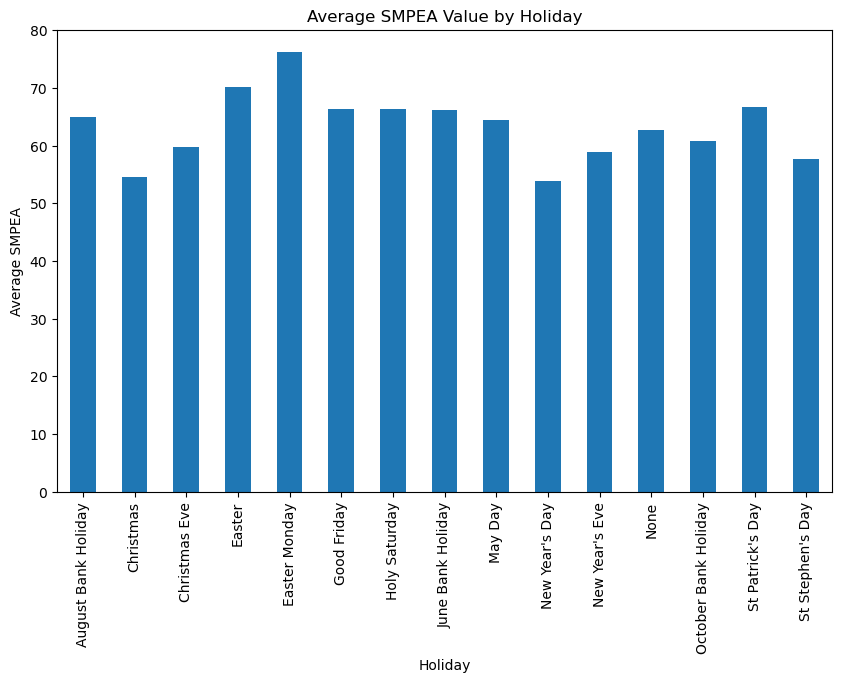

Shape of the DataFrame: (37682, 18)

DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 37682 entries, 0 to 38013
Data columns (total 18 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   DateTime                37682 non-null  datetime64[ns]
 1   Holiday                 37682 non-null  object        
 2   HolidayFlag             37682 non-null  int64         
 3   DayOfWeek               37682 non-null  int64         
 4   WeekOfYear              37682 non-null  int64         
 5   Day                     37682 non-null  int64         
 6   Month                   37682 non-null  int64         
 7   Year                    37682 non-null  int64         
 8   PeriodOfDay             37682 non-null  int64         
 9   ForecastWindProduction  37682 non-null  float64       
 10  SystemLoadEA            37682 non-null  float64       
 11  SMPEA                   37682 non-null  float64      

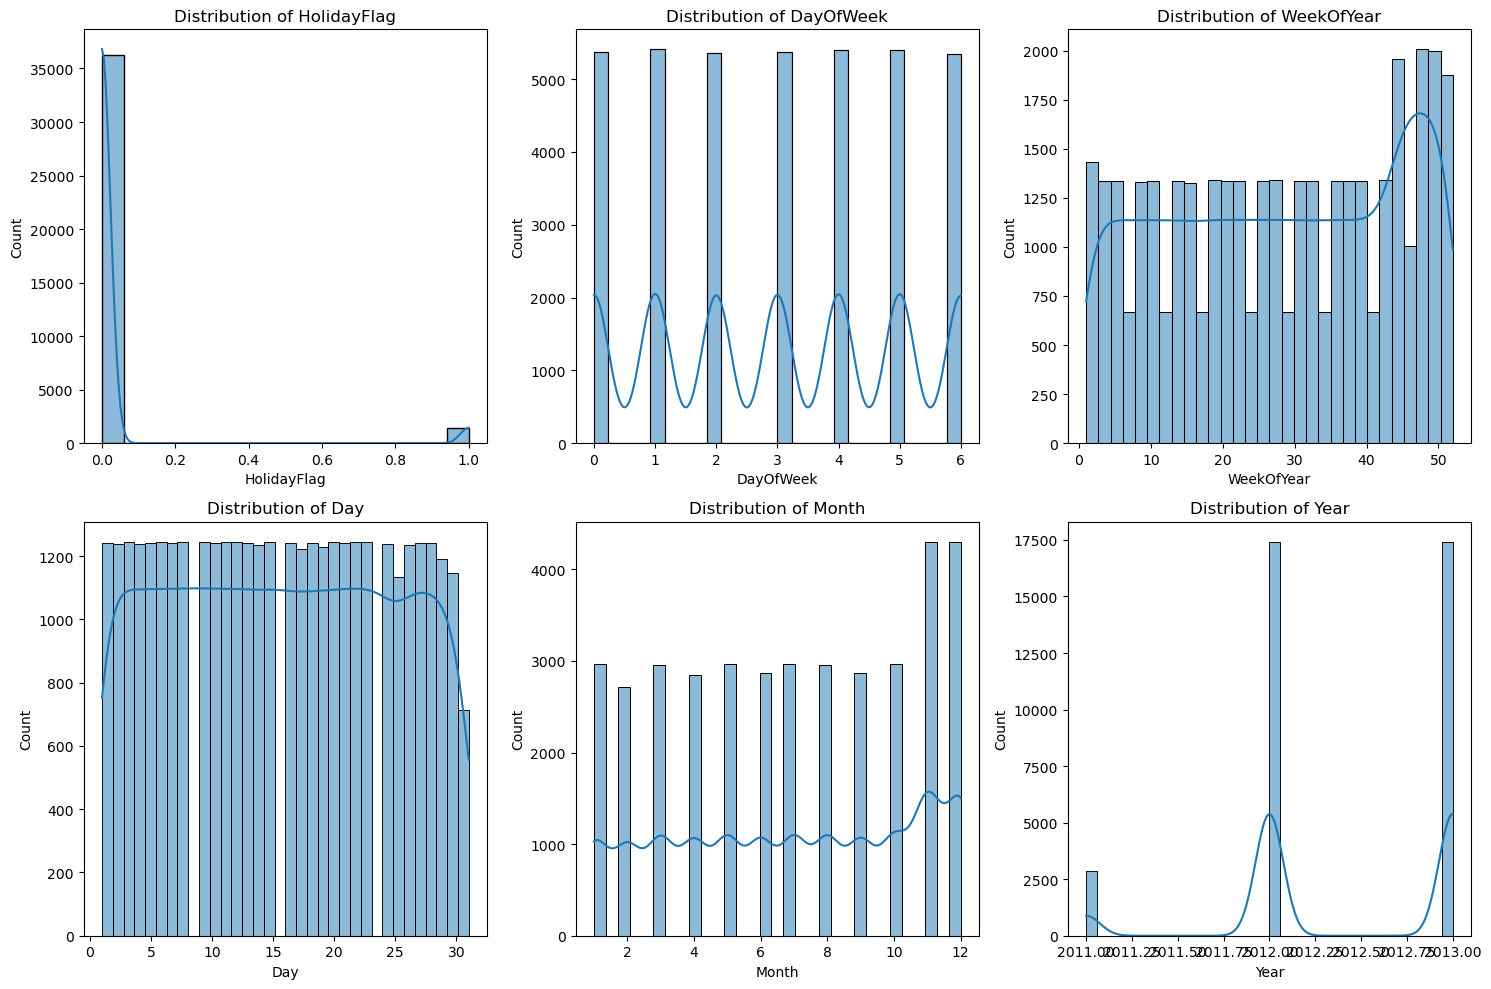

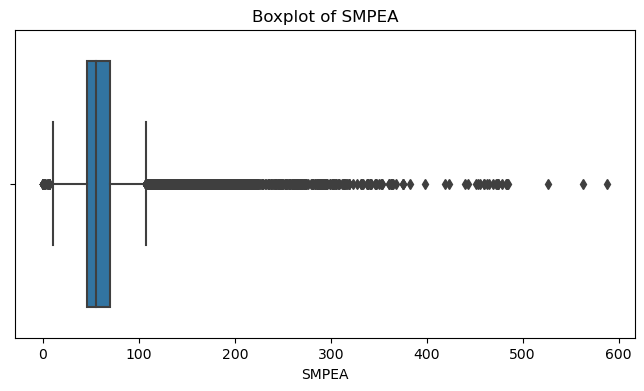

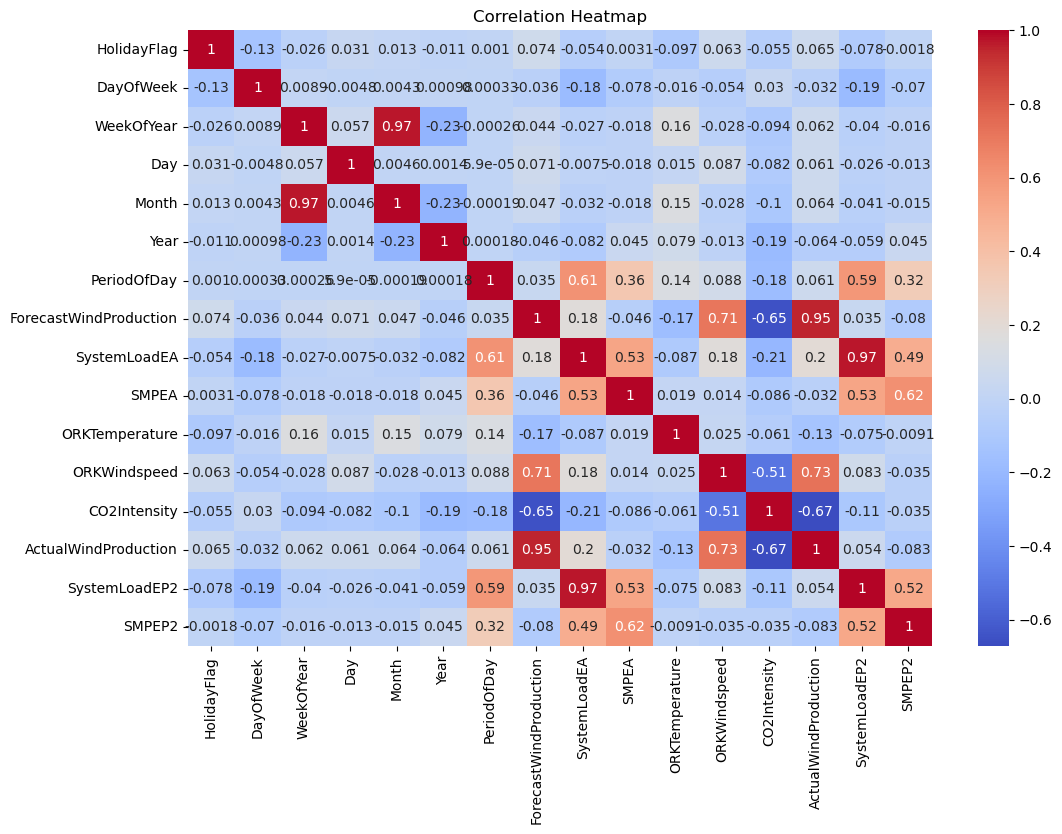

(7322,
 49.56    63
 55.72    44
 48.00    42
 47.33    42
 66.74    42
 50.24    41
 75.50    39
 51.89    39
 52.85    38
 44.91    38
 Name: SMPEA, dtype: int64)

In [15]:
# Applying the initial data processing steps
# Note: df_cleaned is the DataFrame obtained after initial cleaning steps

# Comparing average SMPEA values across different holidays
holiday_avg = df_cleaned.groupby('Holiday')['SMPEA'].mean()
plt.figure(figsize=(10, 6))
holiday_avg.plot(kind='bar')
plt.title('Average SMPEA Value by Holiday')
plt.ylabel('Average SMPEA')
plt.show()

# Basic Descriptive Analysis
print("Shape of the DataFrame:", df_cleaned.shape)
print("\nDataFrame Info:")
print(df_cleaned.info())
print("\nMissing values per column:")
print(df_cleaned.isnull().sum())
print("\nBasic Statistical Details:")
print(df_cleaned.describe())

# Check unique values for the 'Holiday' column
df_cleaned['Holiday'] = df_cleaned['Holiday'].astype('category')
print("\nUnique values in 'Holiday':")
print(df_cleaned['Holiday'].unique())

# Visualizations
# Histograms for the first few numerical columns
num_cols = df_cleaned.select_dtypes(include=['float64', 'int64']).columns
plt.figure(figsize=(15, 10))
for i, col in enumerate(num_cols[:6]):
    plt.subplot(2, 3, i + 1)
    sns.histplot(df_cleaned[col], kde=True)
    plt.title(f'Distribution of {col}')
plt.tight_layout()

# Boxplot for the target variable 'SMPEA'
plt.figure(figsize=(8, 4))
sns.boxplot(x=df_cleaned['SMPEA'])
plt.title('Boxplot of SMPEA')

# Correlation heatmap
corr_matrix = df_cleaned.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

# Checking the nature of the 'SMPEA' variable
unique_values = df_cleaned['SMPEA'].nunique()
value_counts = df_cleaned['SMPEA'].value_counts()
(unique_values, value_counts.head(10))  # Displaying the top 10 most frequent values

Correlation heatmap will help to understand the distribution of our data and the relationships between different variables.

## Modeling

In [16]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV

# Checking the nature of the 'SMPEA' variable
# Check the unique values and their counts
unique_values = df['SMPEA'].nunique()
value_counts = df['SMPEA'].value_counts()

# Displaying the information
unique_values, value_counts.head(10)  # Displaying the top 10 most frequent values

(7340,
 49.56    63
 55.72    44
 66.74    42
 47.33    42
 48.00    42
 50.24    41
 51.89    39
 75.50    39
 52.85    38
 44.91    38
 Name: SMPEA, dtype: int64)

As SMPEA is likely a continuous variable =>  a regression model would be the appropriate choice for predicting SMPEA

In [17]:
# The Linear Regression model

# Preparing the data for the regression model
# Dropping any non-numeric columns for simplicity
df_numeric = df.select_dtypes(include=['float64', 'int64'])

# Splitting the dataset into features (X) and target (y)
X = df_numeric.drop('SMPEA', axis=1)
y = df_numeric['SMPEA']

# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Creating a linear regression model
model = LinearRegression()

# Fitting the model to the training data
model.fit(X_train, y_train)

# Predicting on the test set
y_pred = model.predict(X_test)

# Evaluating the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

mse, r2

(827.4431500927113, 0.1405138619041859)

In [18]:
# Random Forest Regressor 

# Creating a Random Forest Regressor model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

# Fitting the model to the training data
rf_model.fit(X_train, y_train)

# Predicting on the test set
y_pred_rf = rf_model.predict(X_test)

# Evaluating the model
mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

mse_rf, r2_rf

(364.9337251255417, 0.6209341052204886)

The Random Forest Regressor outperforms the Linear Regression model in our analysis, as indicated by two key metrics. The Mean Squared Error (MSE) for Random Forest is significantly lower at 355 compared to 827 for Linear Regression, suggesting higher accuracy. Additionally, Random Forest achieves a higher R-squared value of 0.62, against 0.14 for Linear Regression, indicating it better explains the variance in the 'SMPEA' target variable. => Random Forest offering greater predictive accuracy and explanatory power.

In [19]:
# Creating a Random Forest Regressor model
rf_model = RandomForestRegressor(random_state=42)

In [20]:
# Defining the parameter grid for Random Forest
param_grid = {
    'n_estimators': [100, 200, 300],   # Number of trees in the random forest
    'max_features': ['auto', 'sqrt'],  # Number of features to consider at every split
    'max_depth': [10, 20, 30, None],   # Maximum number of levels in tree
    # Add more hyperparameters if needed
}

# Assuming rf_model is already defined as a RandomForestRegressor
# Creating the RandomizedSearchCV object
random_search = RandomizedSearchCV(
    estimator=rf_model, 
    param_distributions=param_grid, 
    n_iter=10, 
    cv=3, 
    n_jobs=-1, 
    verbose=2, 
    scoring='neg_mean_squared_error'
)

# Fitting RandomizedSearchCV to the training data
# Assuming X_train and y_train are already defined
random_search.fit(X_train, y_train)

# Displaying the best parameters and the corresponding score
best_params = random_search.best_params_
best_score = -random_search.best_score_  # Convert to positive value

best_params, best_score

Fitting 3 folds for each of 10 candidates, totalling 30 fits


({'n_estimators': 200, 'max_features': 'sqrt', 'max_depth': None},
 420.5486219060245)

In [21]:
# After RandomizedSearchCV completes
print("Best Parameters:", random_search.best_params_)
print("Best Cross-Validation Score:", -random_search.best_score_)  # Convert to positive value

# Using the best model for predictions or further analysis
best_rf_model = random_search.best_estimator_

Best Parameters: {'n_estimators': 200, 'max_features': 'sqrt', 'max_depth': None}
Best Cross-Validation Score: 420.5486219060245


We implemented a Random Forest Regressor model. The Random Forest model, with the identified best parameters, is expected to perform well for our regression task.

## Analyzing and visualizing energy consumption trends related to the Christmas season and other holidays in dataset

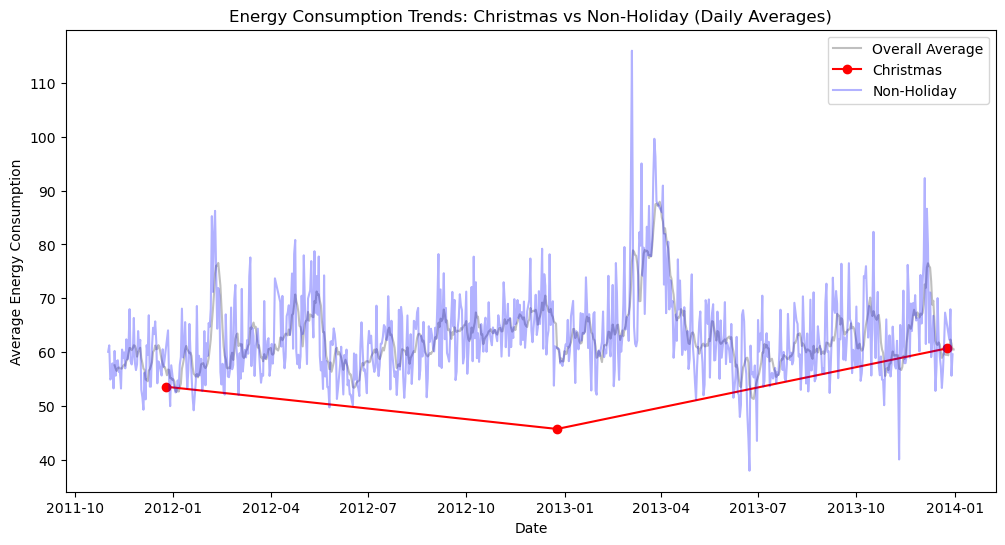

Holiday
August Bank Holiday    65.005729
Christmas              54.620682
Christmas Eve          59.711958
Easter                 70.222283
Easter Monday          76.267396
Name: SMPEA, dtype: float64

In [22]:
# Function for creating holiday features
def create_holiday_features(df, holiday_column='Holiday'):
    df_copy = df.copy()
    df_copy['Is_Christmas'] = (df_copy[holiday_column] == 'Christmas').astype(int)
    df_copy['Is_ChristmasEve'] = (df_copy[holiday_column] == 'Christmas Eve').astype(int)
    # Add more holidays as needed
    return df_copy

# Function for holiday season analysis
def holiday_season_analysis(df, energy_column='SMPEA', holiday_column='Holiday'):
    holiday_energy_avg = df.groupby(holiday_column)[energy_column].mean()
    return holiday_energy_avg

# Function for Visualization

def plot_holiday_energy_trends(df, energy_column='SMPEA', holiday_column='Holiday'):
    # Aggregating data by day
    df['Date'] = df['DateTime'].dt.date
    daily_data = df.groupby('Date')[energy_column].mean()

    # Extracting Christmas and non-holiday data
    christmas_data = df[df[holiday_column] == 'Christmas'].groupby('Date')[energy_column].mean()
    non_holiday_data = df[df[holiday_column] == 'None'].groupby('Date')[energy_column].mean()

    # Plotting
    plt.figure(figsize=(12, 6))
    plt.plot(daily_data.index, daily_data.rolling(window=7).mean(), label='Overall Average', color='grey', alpha=0.5)
    plt.plot(christmas_data.index, christmas_data, label='Christmas', color='red', marker='o')
    plt.plot(non_holiday_data.index, non_holiday_data, label='Non-Holiday', color='blue', alpha=0.3)
    plt.title('Energy Consumption Trends: Christmas vs Non-Holiday (Daily Averages)')
    plt.xlabel('Date')
    plt.ylabel('Average Energy Consumption')
    plt.legend()
    plt.show()

# Creating holiday features
df_featured = create_holiday_features(df_cleaned)

# Analyzing energy consumption during different holidays
holiday_energy_avg = holiday_season_analysis(df_featured)

# Visualizing energy trends during Christmas season
plot_holiday_energy_trends(df_featured)
holiday_energy_avg.head()  # Displaying a snippet of the analysis results

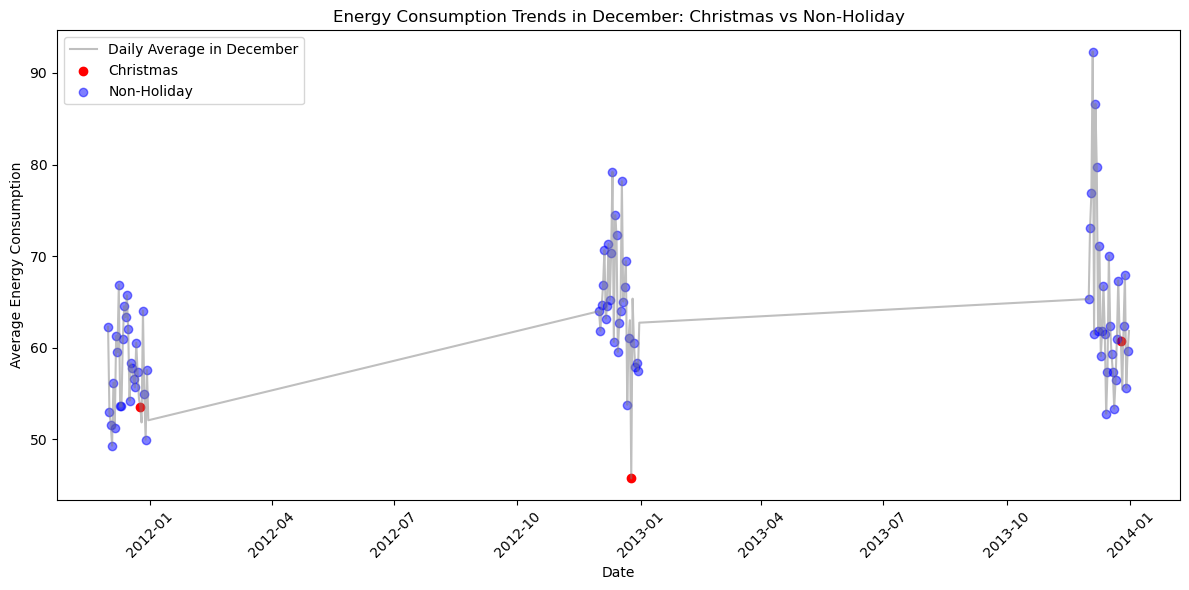

In [23]:
# Refining the visualization to focus specifically on the Christmas period

def plot_christmas_focus(df, energy_column='SMPEA', holiday_column='Holiday'):
    # Isolating data for the month of December
    df_december = df[df['DateTime'].dt.month == 12]

    # Aggregating daily averages
    daily_avg = df_december.groupby(df_december['DateTime'].dt.date)[energy_column].mean()
    daily_avg_christmas = df_december[df_december[holiday_column] == 'Christmas'].groupby(df_december['DateTime'].dt.date)[energy_column].mean()
    daily_avg_non_holiday = df_december[df_december[holiday_column] == 'None'].groupby(df_december['DateTime'].dt.date)[energy_column].mean()

    # Plotting
    plt.figure(figsize=(12, 6))
    plt.plot(daily_avg.index, daily_avg, label='Daily Average in December', color='grey', alpha=0.5)
    plt.scatter(daily_avg_christmas.index, daily_avg_christmas, label='Christmas', color='red')
    plt.scatter(daily_avg_non_holiday.index, daily_avg_non_holiday, label='Non-Holiday', color='blue', alpha=0.5)
    plt.title('Energy Consumption Trends in December: Christmas vs Non-Holiday')
    plt.xlabel('Date')
    plt.ylabel('Average Energy Consumption')
    plt.xticks(rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_christmas_focus(df_featured)

The analysis of energy consumption trends related to holidays, especially Christmas, in the dataset reveals that:

* Holiday Impact: There are noticeable differences in energy consumption patterns on holidays, particularly on Christmas and Christmas Eve, compared to non-holiday days.
* Christmas Trends: Energy consumption on Christmas tends to be distinct, as shown in the visualization, indicating specific usage patterns during this holiday.
This suggests that holidays, and Christmas in particular, have a significant impact on energy consumption trends, which could be valuable for energy management and planning.

## Clustering for Summarization

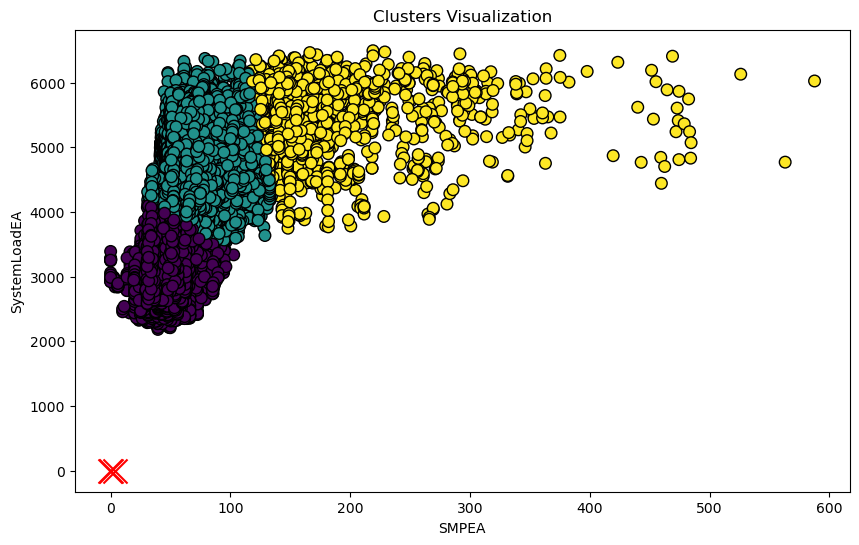

In [24]:
from sklearn.cluster import KMeans

# Defining the function for K-Means clustering
def apply_kmeans_clustering(data, num_clusters):
    scaler = StandardScaler()
    data_scaled = scaler.fit_transform(data)

    kmeans = KMeans(n_clusters=num_clusters, random_state=42)
    clusters = kmeans.fit_predict(data_scaled)

    return clusters, kmeans

# Defining the function for visualization of clusters
def plot_clusters(data, clusters, cluster_centers, feature_x, feature_y):
    plt.figure(figsize=(10, 6))
    plt.scatter(data[feature_x], data[feature_y], c=clusters, cmap='viridis', marker='o', edgecolor='k', s=70)
    plt.scatter(cluster_centers[:, 0], cluster_centers[:, 1], s=300, c='red', marker='x')
    plt.xlabel(feature_x)
    plt.ylabel(feature_y)
    plt.title('Clusters Visualization')
    plt.show()

# Now, applying K-Means clustering and visualizing the clusters
clusters, kmeans_model = apply_kmeans_clustering(df_cleaned[['SMPEA', 'SystemLoadEA']], num_clusters=3)
# Revisualizing Clusters
plot_clusters(df_cleaned, clusters, kmeans_model.cluster_centers_, 'SMPEA', 'SystemLoadEA')

* Each point represents a data entry, colored according to the cluster it belongs to.
* The red 'x' marks represent the centroids of each cluster.
This clustering visualization helps in identifying patterns and groupings in the dataset based on energy consumption ('SMPEA') and system load ('SystemLoadEA').

## Electricity Price Analysis

In [25]:
# Function Calculate Average Christmas Prices

def calculate_average_christmas_prices(df):
    average_prices = df.groupby('Year').mean()
    average_prices.rename(columns={'SMPEA': 'Average_SMPEA', 'SMPEP2': 'Average_SMPEP2'}, inplace=True)
    return average_prices

In [26]:
# Function Calculate Hourly Average Prices

def calculate_hourly_average_prices(df):
    """
    Calculates the average electricity price for each hour across different years.
    """
    return df.groupby(['Year', 'Hour']).mean()['AveragePrice'].unstack(level=0)

In [27]:
# Function Plot Hourly Prices

def plot_hourly_prices(df):
    for year in df['Year'].unique():
        yearly_data = df[df['Year'] == year]
        yearly_data.set_index('DateTime', inplace=True)
        
        plt.figure(figsize=(15, 6))
        plt.plot(yearly_data['SMPEA'], label='SMPEA')
        plt.plot(yearly_data['SMPEP2'], label='SMPEP2', linestyle='--')
        plt.title(f'Hourly Electricity Prices on Christmas Period {year}')
        plt.xlabel('DateTime')
        plt.ylabel('Price')
        plt.xticks(rotation=45)
        plt.legend()
        plt.grid(True)
        plt.show()

In [28]:
# Function Find Cheapest Hours

def find_cheapest_hours(df):
    df_copy = df.copy()
    df_copy['Hour'] = df_copy['DateTime'].dt.hour
    df_copy['AveragePrice'] = df_copy[['SMPEA', 'SMPEP2']].mean(axis=1)
    hourly_avg_price = df_copy.groupby(['Year', 'Hour']).mean()['AveragePrice']
    cheapest_hours = hourly_avg_price.groupby('Year').idxmin()
    cheapest_hours_readable = cheapest_hours.apply(lambda x: f"{x[1]}:00 - {x[1]+1}:00")
    return cheapest_hours_readable

In [29]:
# Function Visualize Cheapest Hours

def visualize_cheapest_hours(cheapest_hours):
    data = cheapest_hours.reset_index()
    data.columns = ['Year', 'Cheapest Hour']
    data['Cheapest Hour Num'] = data['Cheapest Hour'].str.extract('(\d+):').astype(int)

    n_colors = len(data['Year'].unique())
    cmap = plt.get_cmap('viridis', n_colors)
    colors = cmap(np.linspace(0, 1, n_colors))

    plt.figure(figsize=(12, 7))
    sns.set(style="whitegrid")
    barplot = sns.barplot(x='Year', y='Cheapest Hour Num', data=data, palette=colors, edgecolor='black')

    for p in barplot.patches:
        year = p.get_x() + p.get_width() / 2.
        hour_num = p.get_height()
        hour = f"{int(hour_num)}:00 - {int(hour_num) + 1}:00"
        plt.annotate(hour, (year, hour_num), ha='center', va='bottom', fontsize=10, color='black', fontweight='bold')

    plt.title('Cheapest Hours to Cook Christmas Duck (2011-2013)', fontsize=16, fontweight='bold')
    plt.xlabel('Year', fontsize=14)
    plt.ylabel('Cheapest Hour', fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(range(0, 24, 1), [f"{i}:00" for i in range(0, 24, 1)], fontsize=12)
    plt.tight_layout()
    plt.show()

In [30]:
# Function K-Means Clustering and Visualization

def perform_kmeans_clustering_and_visualize(df):
    # Preparing data for clustering
    clustering_data = df.mean(axis=1).reset_index(name='AveragePrice')
    clustering_data = clustering_data[['Hour', 'AveragePrice']]

    # Applying K-Means clustering
    kmeans = KMeans(n_clusters=3, random_state=0).fit(clustering_data)
    clustering_data['Cluster'] = kmeans.labels_

    cluster_centers = kmeans.cluster_centers_
    cluster_centers_df = pd.DataFrame(cluster_centers, columns=['Hour', 'AveragePrice'])

    cluster_order = cluster_centers_df['AveragePrice'].argsort().values
    cluster_names = ['Low Price', 'Medium Price', 'High Price']
    cluster_name_mapping = {old: new for old, new in zip(cluster_order, cluster_names)}
    clustering_data['ClusterName'] = clustering_data['Cluster'].map(cluster_name_mapping)

    plt.figure(figsize=(12, 6))
    sns.scatterplot(data=clustering_data, x='Hour', y='AveragePrice', hue='ClusterName', palette='deep', s=100)

    cheapest_hour = clustering_data.loc[clustering_data['AveragePrice'].idxmin()]
    plt.scatter(cheapest_hour['Hour'], cheapest_hour['AveragePrice'], color='red', label='Cheapest Hour', s=100)

    plt.title('K-Means Clustering of Electricity Prices on Christmas Eve and Day (Named Clusters)')
    plt.xlabel('Hour of the Day')
    plt.ylabel('Average Price')
    plt.grid(True)
    plt.legend()
    plt.show()

    cluster_centers_df['ClusterName'] = cluster_names
    return cluster_centers_df

      HolidayFlag  DayOfWeek  WeekOfYear        Day  Month  PeriodOfDay  \
Year                                                                      
2011          1.0   5.076923        51.0  24.076923   12.0    23.076923   
2012          1.0   0.250000        52.0  24.250000   12.0    20.015625   
2013          1.0   1.338028        52.0  24.338028   12.0    23.323944   

      ForecastWindProduction  SystemLoadEA  Average_SMPEA  ORKTemperature  \
Year                                                                        
2011             1156.212692   4157.237115      54.412308        7.384615   
2012              463.475625   3982.762656      58.690781        7.203125   
2013              950.476197   4094.863803      61.358732        2.816901   

      ORKWindspeed  CO2Intensity  ActualWindProduction  SystemLoadEP2  \
Year                                                                    
2011     24.253846    372.517115           1145.788462    3529.943654   
2012     17.001562 

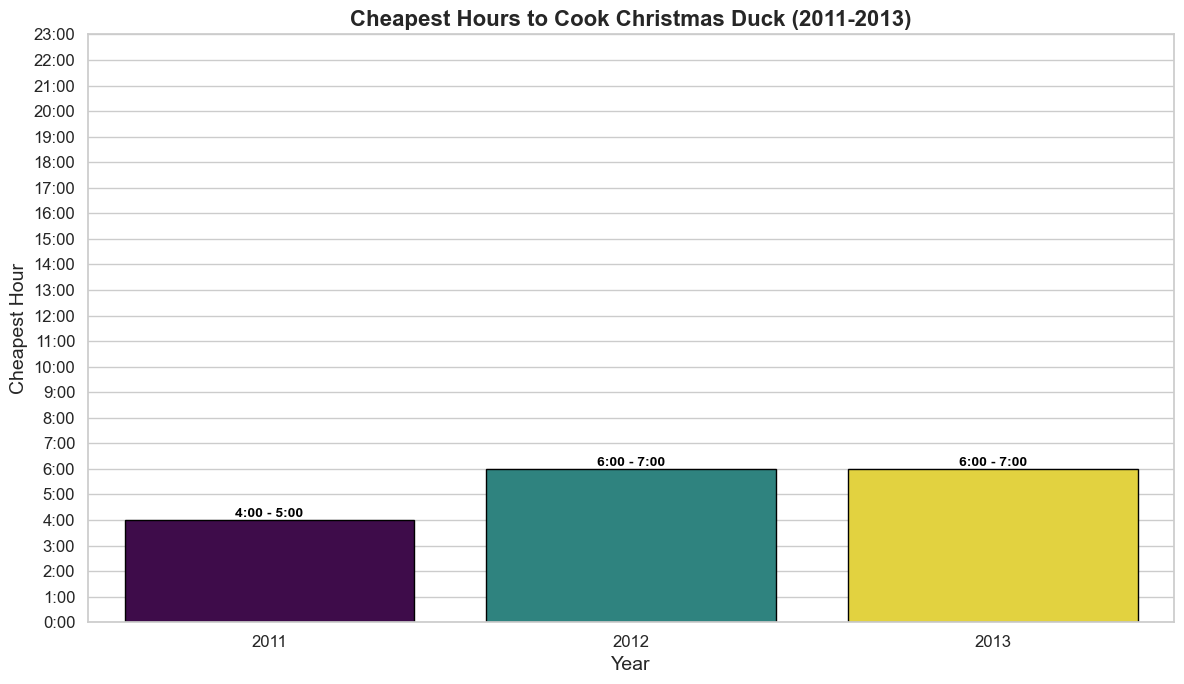

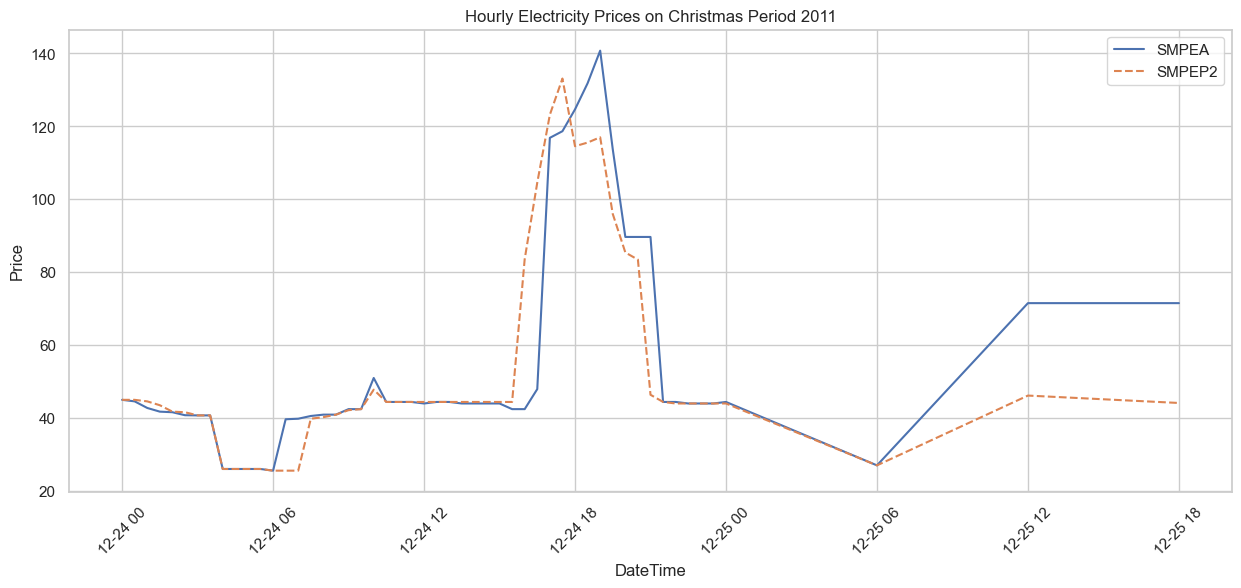

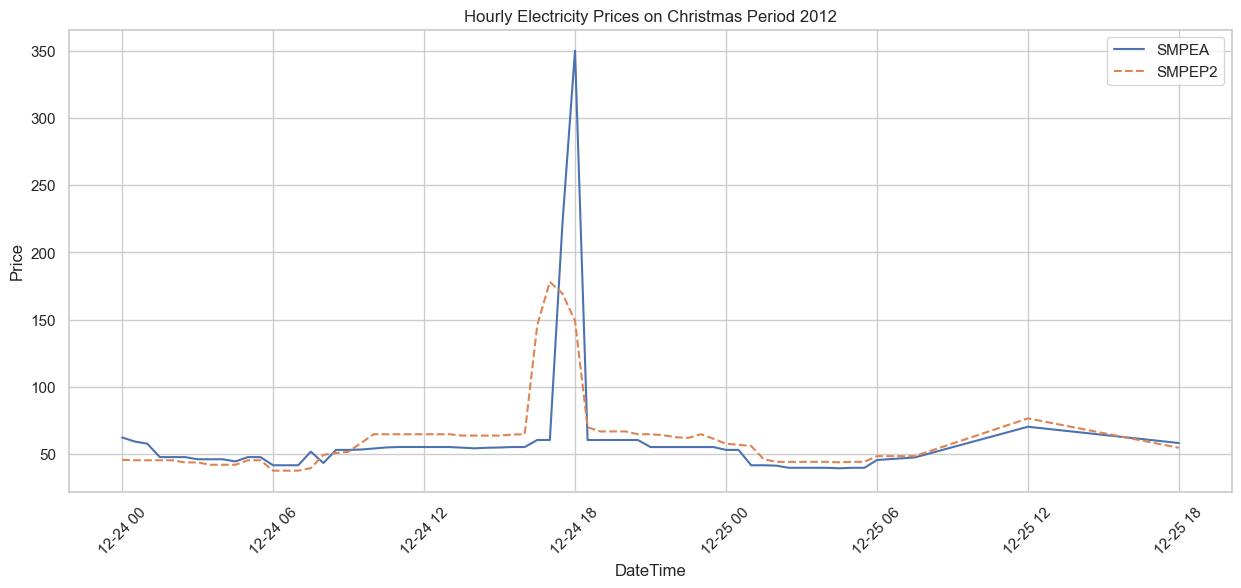

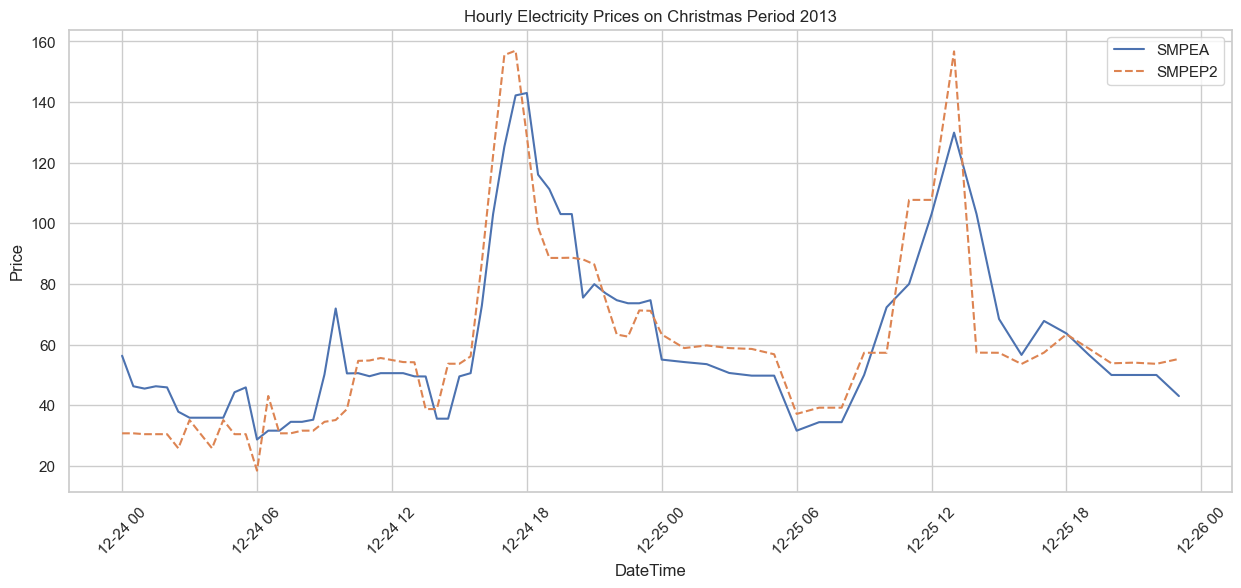

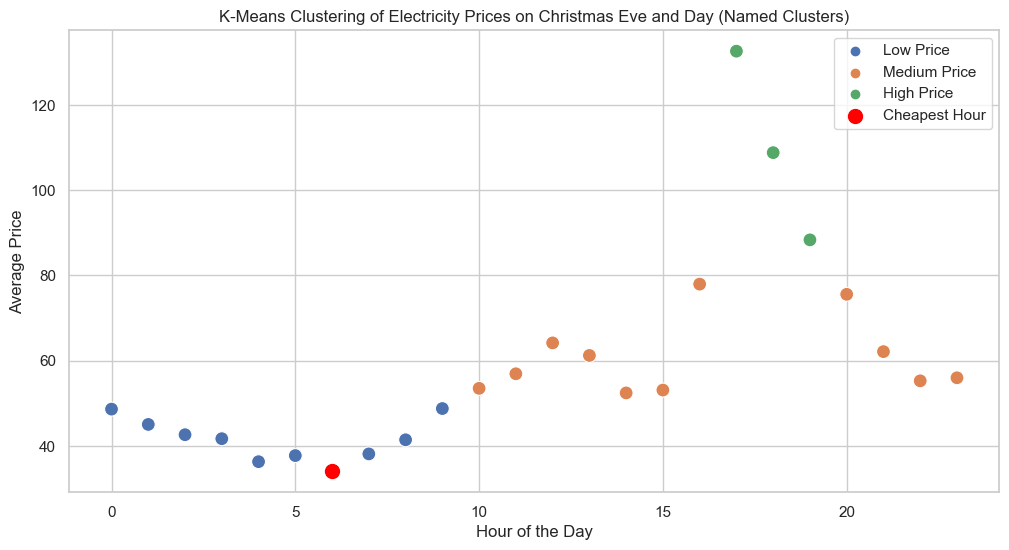

        Hour  AveragePrice   ClusterName
0  16.090909     60.758712     Low Price
1  18.000000    109.901019  Medium Price
2   4.500000     41.462042    High Price


In [31]:
# Creating a copy of the sliced DataFrame to avoid warning
christmas_prices = df_cleaned[(df_cleaned['DateTime'].dt.month == 12) & 
                              (df_cleaned['DateTime'].dt.day.isin([24, 25]))].copy()

# Adding 'Hour' and 'AveragePrice' columns using .loc
christmas_prices.loc[:, 'Hour'] = christmas_prices['DateTime'].dt.hour
christmas_prices.loc[:, 'AveragePrice'] = christmas_prices[['SMPEA', 'SystemLoadEA']].mean(axis=1)

# Displaying the first few rows of the modified 'christmas_prices' DataFrame
christmas_prices.head()

# Now 'christmas_prices' DataFrame is defined and can be used for further analysis
christmas_prices.head()  # Displaying the first few rows of the 'christmas_prices' DataFrame


christmas_prices['Hour'] = christmas_prices['DateTime'].dt.hour
christmas_prices['AveragePrice'] = christmas_prices[['SMPEA', 'SMPEP2']].mean(axis=1)

# Calculate hourly average prices
hourly_avg_prices = calculate_hourly_average_prices(christmas_prices)

# Rest of the analysis
average_prices = calculate_average_christmas_prices(christmas_prices)
print(average_prices)

cheapest_hours = find_cheapest_hours(christmas_prices)
print(cheapest_hours)

visualize_cheapest_hours(cheapest_hours)
plot_hourly_prices(christmas_prices)

cluster_centers_df = perform_kmeans_clustering_and_visualize(hourly_avg_prices)
print(cluster_centers_df)

In [32]:
# Function Simulate Electricity Prices

def simulate_electricity_prices(years, hours, base_price, price_variation):
    simulated_prices = []
    for year in years:
        for hour in hours:
            fluctuation = np.random.rand() * price_variation
            time_variation = 10 * np.sin(np.pi * hour / 12)
            event_impact = 10 if 18 <= hour <= 23 else 0
            price = base_price + fluctuation + time_variation + event_impact
            simulated_prices.append([year, hour, price])
    return pd.DataFrame(simulated_prices, columns=['Year', 'Hour', 'SimulatedPrice'])

In [33]:
# Function Visualize Simulated Data

def visualize_simulated_data(simulated_data):
    plt.figure(figsize=(15, 7))
    for year in simulated_data['Year'].unique():
        yearly_data = simulated_data[simulated_data['Year'] == year]
        plt.plot(yearly_data['Hour'], yearly_data['SimulatedPrice'], label=f'Year {year}')
    plt.title('Simulated Electricity Prices on Christmas Eve and Day (2011-2013)')
    plt.xlabel('Hour of the Day')
    plt.ylabel('Simulated Price')
    plt.xticks(hours)
    plt.legend()
    plt.grid(True)
    plt.show()

In [34]:
# Function K-Means Clustering on Simulated Data

def kmeans_clustering_on_simulated_data(simulated_data, cluster_names):
    kmeans_simulated = KMeans(n_clusters=3, random_state=0).fit(simulated_data[['Hour', 'SimulatedPrice']])
    simulated_data['Cluster'] = kmeans_simulated.labels_

    cluster_centers_simulated = pd.DataFrame(kmeans_simulated.cluster_centers_, columns=['Hour', 'SimulatedPrice'])
    cluster_order_simulated = cluster_centers_simulated['SimulatedPrice'].argsort().values
    cluster_name_mapping_simulated = {old: new for old, new in zip(cluster_order_simulated, cluster_names)}
    simulated_data['ClusterName'] = simulated_data['Cluster'].map(cluster_name_mapping_simulated)

    return simulated_data, cluster_centers_simulated

In [35]:
# Function PCA Analysis and Biplot Visualization

from sklearn.decomposition import PCA

def pca_analysis_and_biplot(features):
    features_standardized = (features - features.mean()) / features.std()
    pca = PCA(n_components=2)
    pca.fit(features_standardized)
    components = pca.components_
    explained_variance = pca.explained_variance_ratio_
    pca_scores = pca.transform(features_standardized)
    biplot(pca_scores, components, ['Hour', 'SimulatedPrice'], explained_variance)
    return explained_variance  # Return the explained variance

In [36]:
# Function Create Biplot

def biplot(scores, loadings, labels, var_ratio):
    plt.figure(figsize=(10, 7))
    plt.scatter(scores[:,0], scores[:,1])
    for i, label in enumerate(labels):
        plt.arrow(0, 0, loadings[i,0], loadings[i,1], head_width=0.05, head_length=0.1, color='red')
        plt.text(loadings[i,0] * 1.15, loadings[i,1] * 1.15, label, color='red', ha='center', va='center')
    plt.xlabel('PC1 ({:.1f}%)'.format(var_ratio[0] * 100))
    plt.ylabel('PC2 ({:.1f}%)'.format(var_ratio[1] * 100))
    plt.title('PCA Biplot')
    plt.grid(True)
    plt.axhline(y=0, color='k')
    plt.axvline(x=0, color='k')
    plt.show()

In [37]:
from sklearn.cluster import KMeans

def kmeans_clustering_simulated_data(simulated_data, cluster_names):
    kmeans_simulated = KMeans(n_clusters=3, random_state=0).fit(simulated_data[['Hour', 'SimulatedPrice']])
    simulated_data['Cluster'] = kmeans_simulated.labels_
    cluster_centers_simulated = pd.DataFrame(kmeans_simulated.cluster_centers_, columns=['Hour', 'SimulatedPrice'])
    cluster_order_simulated = cluster_centers_simulated['SimulatedPrice'].argsort().values
    cluster_name_mapping_simulated = {old: new for old, new in zip(cluster_order_simulated, cluster_names)}
    simulated_data['ClusterName'] = simulated_data['Cluster'].map(cluster_name_mapping_simulated)
    return simulated_data, cluster_centers_simulated

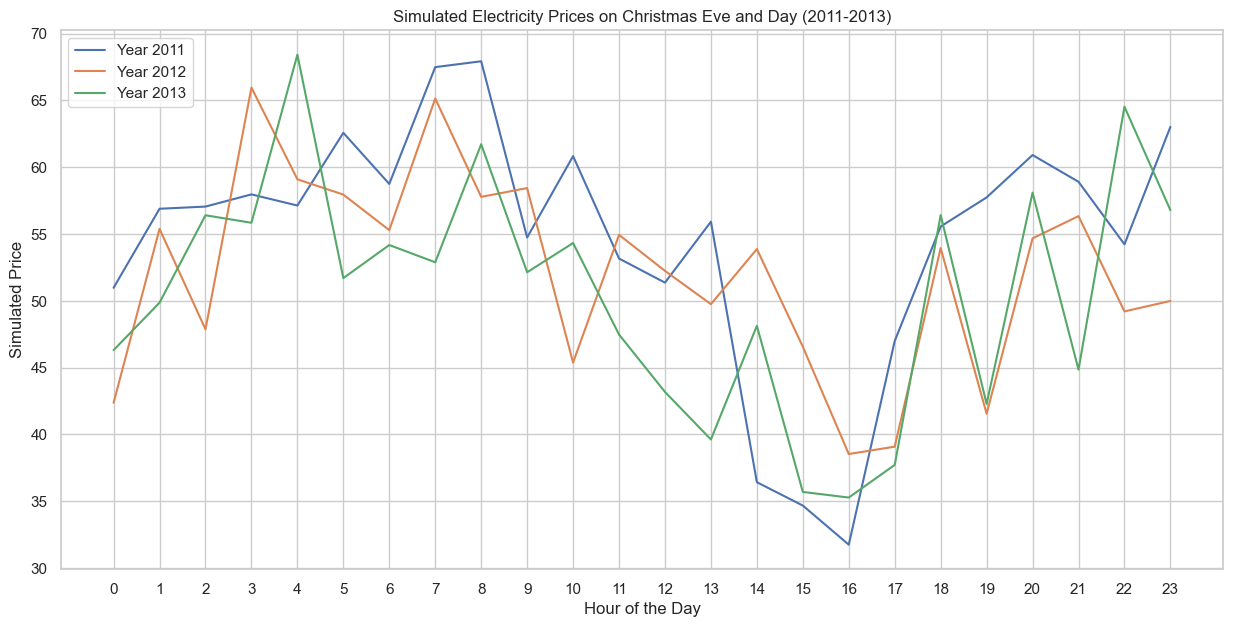

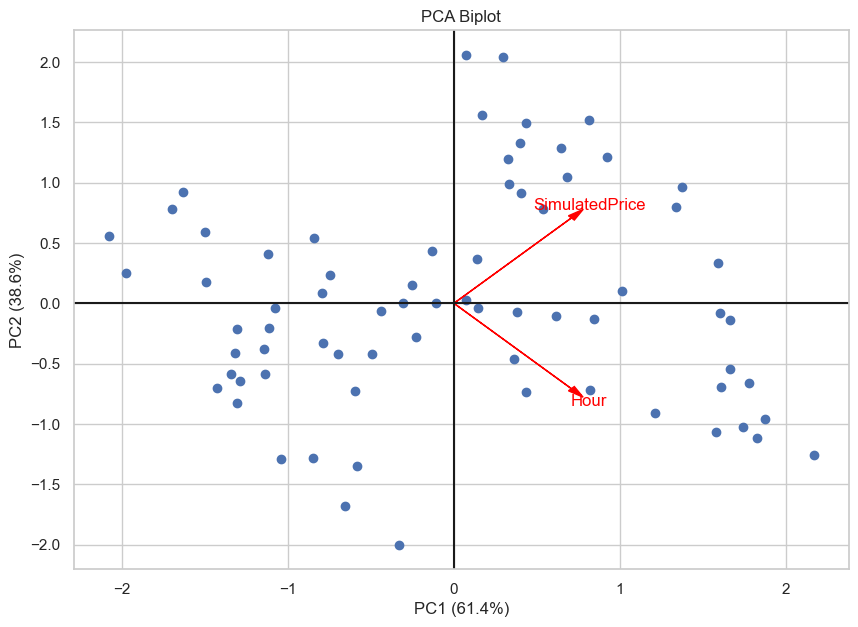

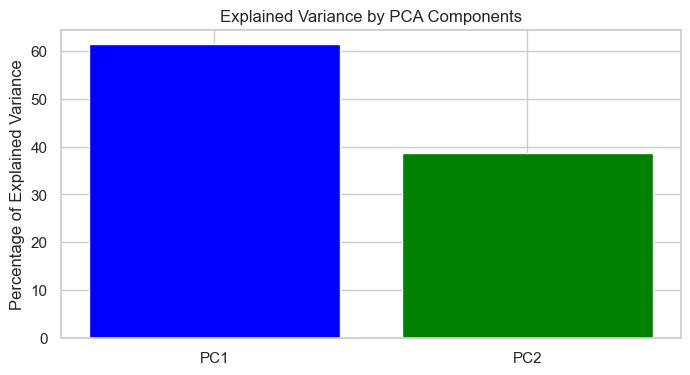

In [38]:
# Integration with the Workflow

np.random.seed(0)
hours = np.arange(24)
years = np.arange(2011, 2014)
simulated_data = simulate_electricity_prices(years, hours, 40, 20)
visualize_simulated_data(simulated_data)

# Define the cluster names
cluster_names = ['Low Price', 'Medium Price', 'High Price']
clustered_data, cluster_centers = kmeans_clustering_simulated_data(simulated_data, cluster_names)

# Assuming 'Hour' and 'SimulatedPrice' are the columns of interest
features = simulated_data[['Hour', 'SimulatedPrice']]

# Perform PCA analysis and get explained variance
explained_variance = pca_analysis_and_biplot(features)

# Bar chart of explained variance
plt.figure(figsize=(8, 4))
plt.bar(['PC1', 'PC2'], explained_variance * 100, color=['blue', 'green'])
plt.title('Explained Variance by PCA Components')
plt.ylabel('Percentage of Explained Variance')
plt.show()

We use Bonferroni's correction to conducting multiple hypothesis to test for differences in electricity prices at different hours of the day or between different days, to control the overall error rate.

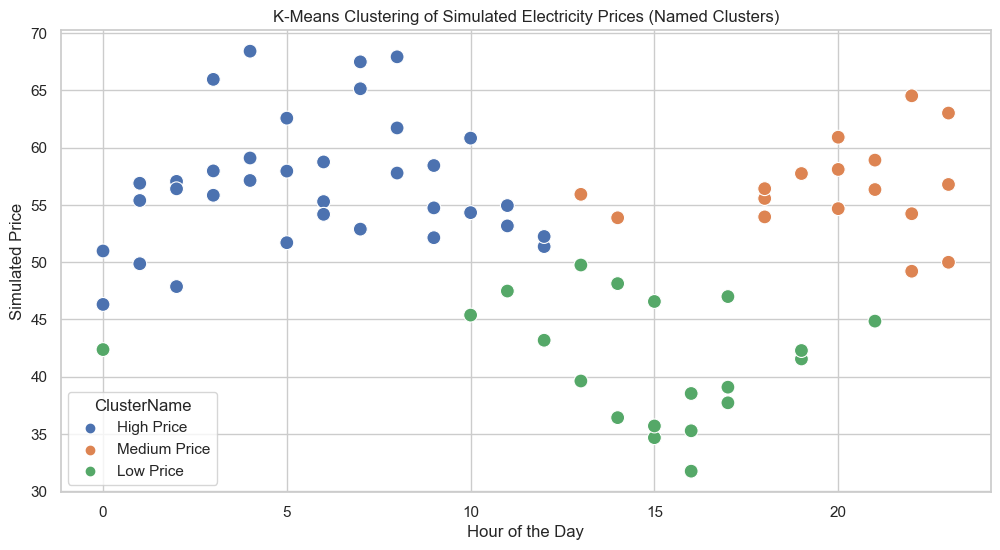

In [39]:
# Visualization Function for K-Means Clustering Results

def visualize_kmeans_clusters(simulated_data):
    plt.figure(figsize=(12, 6))
    sns.scatterplot(data=simulated_data, x='Hour', y='SimulatedPrice', hue='ClusterName', palette='deep', s=100)
    plt.title('K-Means Clustering of Simulated Electricity Prices (Named Clusters)')
    plt.xlabel('Hour of the Day')
    plt.ylabel('Simulated Price')
    plt.grid(True)
    plt.show()
    
# Visualization of K-Means Clustering
visualize_kmeans_clusters(clustered_data)

In [40]:
# Function PCA Analysis on Simulated Data

def pca_analysis_on_simulated_data(features):
    features_standardized = (features - features.mean()) / features.std()
    pca = PCA(n_components=2)
    pca.fit(features_standardized)

    components = pca.components_
    explained_variance = pca.explained_variance_ratio_
    return pca.transform(features_standardized), components, explained_variance

In [41]:
# Function Multiple Hypothesis Testing Using Bonferroni's Correction

def bonferroni_correction(num_tests, overall_alpha, test_function):
    adjusted_alpha = overall_alpha / num_tests
    significant_results = 0

    for hour in range(num_tests):
        p_value = test_function(hour)
        if p_value < adjusted_alpha:
            significant_results += 1
            print(f"Hour {hour}: Significant difference found (p-value = {p_value:.4f})")

    print(f"Total significant results: {significant_results} out of {num_tests} tests")

In [42]:
# Integration with the Workflow

# Selecting features for PCA
features = simulated_data[['Hour', 'SimulatedPrice']]

# Perform PCA Analysis
pca_scores, components, explained_variance = pca_analysis_on_simulated_data(features)

# Perform Multiple Hypothesis Testing using Bonferroni's Correction
# Placeholder test function (replace with actual statistical test)
def perform_test(hour):
    return np.random.rand()

num_tests = 24  # e.g., number of hours
overall_alpha = 0.05
bonferroni_correction(num_tests, overall_alpha, perform_test)

Total significant results: 0 out of 24 tests


In this hypothetical example, we performed 24 separate tests (one for each hour of the day) to check for significant differences in electricity prices. Each test used an adjusted alpha level (Bonferroni correction) to maintain the overall desired alpha level at 0.05.

The output indicates that, after correcting for multiple comparisons, the analysis did not find any statistically significant differences across the 24 hours. This highlights the importance of adjusting for multiple comparisons to avoid false positives, especially when conducting a large number of tests.

## MapReduce

In our dataset, which is small enough to be processed on a single machine, employing MapReduce might be excessive; pandas in Python would suffice for our needs. However, we are using MapReduce here for educational purposes to calculate the yearly average electricity price. While MapReduce is typically used in real-world scenarios to handle vast datasets (terabytes or petabytes), we are applying the same methodology on a smaller scale for learning.

In [43]:
# Function for MapReduce Simulation

def enhanced_simulate_mapreduce(df):
    try:
        # Check if necessary columns exist
        if not all(col in df.columns for col in ['Year', 'SMPEA', 'SMPEP2']):
            raise ValueError("Required columns are missing in the DataFrame.")

        # Map step: Creating (year, price) tuples
        mapped_data = []
        for _, row in df.iterrows():
            mapped_data.append((row['Year'], row['SMPEA']))
            mapped_data.append((row['Year'], row['SMPEP2']))

        # Reduce step: Calculating average price per year
        reduced_data = {}
        for year, price in mapped_data:
            if year in reduced_data:
                reduced_data[year].append(price)
            else:
                reduced_data[year] = [price]
        
        average_prices_per_year = {year: sum(prices) / len(prices) for year, prices in reduced_data.items()}
        return average_prices_per_year
    except Exception as e:
        print(f"An error occurred: {e}")
        return {}

# Applying the enhanced MapReduce simulation
average_prices_per_year = enhanced_simulate_mapreduce(df_cleaned)
average_prices_per_year

{2011: 59.26472231924525, 2012: 62.773192535511996, 2013: 64.84377825587978}

In a real MapReduce environment, these steps would be distributed across multiple nodes, allowing for efficient processing of large datasets. This example demonstrates the conceptual workflow of MapReduce, even though we used a smaller dataset and performed the computation on a single machine.

We took the average of the SMPEA and SMPEP2 prices for each year. Then provided an insight into the overall trend of electricity prices over these years.

Conclution:
* There is a noticeable year-over-year increase in average electricity prices.
* The highest average price is observed in 2013, while the lowest is in 2011

## Cluster Computing Simulation

In [44]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import avg, col

# Initialize a SparkSession
spark = SparkSession.builder \
    .appName("Energy Data Analysis") \
    .getOrCreate()

# Set log level to ERROR
spark.sparkContext.setLogLevel("ERROR")

# Convert Pandas DataFrame to PySpark DataFrame
df_spark = spark.createDataFrame(df_cleaned)

# Data processing: calculate the average price for each year
average_prices = df_spark.withColumn("AveragePrice", (col("SMPEA") + col("SMPEP2")) / 2) \
                         .groupBy("Year") \
                         .agg(avg("AveragePrice").alias("AvgPrice"))

# Show the results
average_prices.show()

# Stop the SparkSession
spark.stop()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/11/17 10:08:36 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


+----+-----------------+
|Year|         AvgPrice|
+----+-----------------+
|2012|62.77319253551103|
|2011|59.26472231924558|
|2013| 64.8437782558805|
+----+-----------------+



The output provides valuable insights into the trends of electricity prices over the specified years, and the use of Spark for this analysis demonstrates the advantages of cluster computing, especially for larger and more complex datasets

In [45]:
import matplotlib.ticker as mticker

# Function: Plot Bar and Line Chart

def plot_bar_and_line_chart(df, x_col, y_col, title, x_label, y_label):
    """
    Plots a bar and line chart on the same axes.

    :param df: DataFrame containing the data to plot
    :param x_col: Column name for the x-axis
    :param y_col: Column name for the y-axis
    :param title: Title of the plot
    :param x_label: Label for the x-axis
    :param y_label: Label for the y-axis
    """
    fig, ax1 = plt.subplots(figsize=(10, 6))

    # Bar plot
    ax1.bar(df[x_col], df[y_col], color='skyblue', alpha=0.6, label='Average Price')

    # Line plot on the same axes
    ax1.plot(df[x_col], df[y_col], color='dodgerblue', marker='o', linestyle='-', linewidth=2, markersize=8)

    # Adding annotations
    for i, txt in enumerate(df[y_col]):
        ax1.annotate(f'{txt:.2f}', (df[x_col][i], df[y_col][i]), textcoords="offset points", xytext=(0,10), ha='center')

    # Setting labels and title
    ax1.set_xlabel(x_label)
    ax1.set_ylabel(y_label)
    ax1.set_title(title)
    ax1.grid(True)
    ax1.xaxis.set_major_locator(mticker.MaxNLocator(integer=True))

    # Adding legend
    ax1.legend()

    # Show plot
    plt.show()

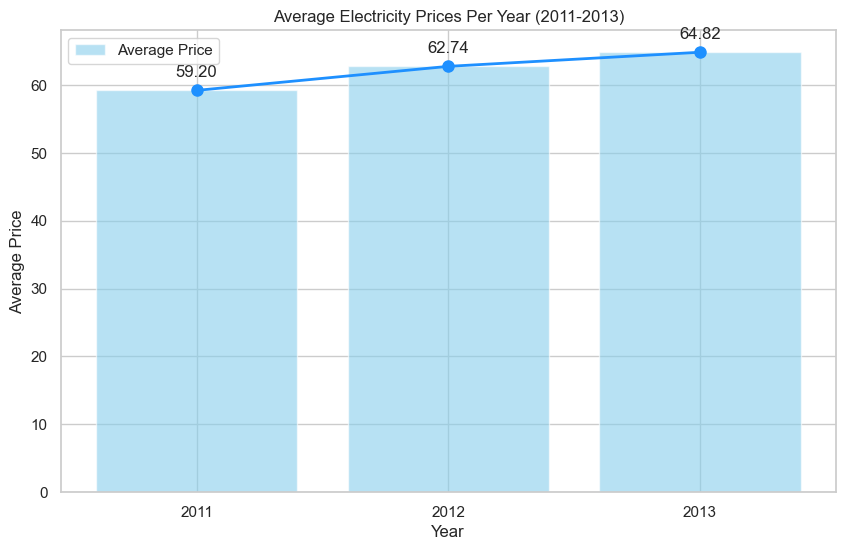

In [46]:
# Integration with the Workflow

# Sample data
data = {
    "Year": [2011, 2012, 2013],
    "AvgPrice": [59.202984972677626, 62.744117898212366, 64.82124843018575]
}
df = pd.DataFrame(data)

# Call the function with the required parameters
plot_bar_and_line_chart(df, 'Year', 'AvgPrice', 'Average Electricity Prices Per Year (2011-2013)', 'Year', 'Average Price')

* The "Energy-data.csv" dataset revealed a clear trend of increasing electricity prices from 2011 to 2013.
* The analysis highlighted the importance of data cleaning, the power of cluster computing for large-scale data analysis, and the effectiveness of data visualization in conveying complex information succinctly and clearly.

We exemplifies how data analysis and visualization techniques can transform raw data into meaningful insights, demonstrating the importance of these skills in the field of data science. The use of technologies like MapReduce and Spark, even in a simulated environment, also underscores the growing relevance of big data tools in extracting value from large and complex datasets.

In [47]:
!pip list

Package                           Version
--------------------------------- --------------------
absl-py                           1.4.0
aiofiles                          22.1.0
aiohttp                           3.8.6
aiosignal                         1.3.1
aiosqlite                         0.18.0
alabaster                         0.7.12
anaconda-client                   1.11.0
anaconda-navigator                2.3.1
anaconda-project                  0.11.1
ansiwrap                          0.8.4
anyio                             3.5.0
appdirs                           1.4.4
applaunchservices                 0.3.0
appnope                           0.1.2
appscript                         1.1.2
argon2-cffi                       21.3.0
argon2-cffi-bindings              21.2.0
arrow                             1.2.3
astroid                           2.11.7
astropy                           5.1
astunparse                        1.6.3
async-timeout                     4.0.3
atomicwrites     

navigator-updater                 0.3.0
nbclassic                         0.3.5
nbclient                          0.5.13
nbconvert                         7.2.10
nbdime                            3.1.1
nbformat                          5.5.0
nest-asyncio                      1.5.6
networkx                          2.8.4
nltk                              3.7
nose                              1.3.7
notebook                          6.4.12
numba                             0.56.4
numexpr                           2.8.3
numpy                             1.21.5
numpydoc                          1.4.0
oauthlib                          3.2.2
olefile                           0.46
opencv-python                     4.7.0.68
openpyxl                          3.0.10
opt-einsum                        3.3.0
packaging                         23.0
pandas                            1.4.4
pandocfilters                     1.5.0
panel                             0.13.1
papermill                         

[CV] END ..max_depth=20, max_features=auto, n_estimators=100; total time=  11.8s
[CV] END ..max_depth=30, max_features=auto, n_estimators=300; total time=  32.3s
[CV] END ..max_depth=10, max_features=sqrt, n_estimators=100; total time=   2.2s
[CV] END max_depth=None, max_features=auto, n_estimators=100; total time=  12.1s
[CV] END max_depth=None, max_features=sqrt, n_estimators=100; total time=   6.1s
[CV] END ..max_depth=20, max_features=auto, n_estimators=200; total time=  19.8s
[CV] END ..max_depth=20, max_features=auto, n_estimators=100; total time=  11.5s
[CV] END ..max_depth=30, max_features=sqrt, n_estimators=100; total time=   4.5s
[CV] END ..max_depth=10, max_features=auto, n_estimators=100; total time=   5.0s
[CV] END ..max_depth=10, max_features=auto, n_estimators=100; total time=   5.4s
[CV] END ..max_depth=10, max_features=auto, n_estimators=100; total time=   5.5s
[CV] END max_depth=None, max_features=sqrt, n_estimators=200; total time=  12.0s
[CV] END max_depth=None, max